In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson

In [86]:
df = pd.read_excel("survei.xlsx")

In [87]:
def convert_answers(row):
    # Jenis Kelamin
    row['Jenis Kelamin'] = 1 if row['Jenis Kelamin'] == 'Laki-laki' else 2
    
    # Umur
    if row['Berapa Umur Anda'] == ' <25 tahun: Usia muda':
        row['Berapa Umur Anda'] = 1
    elif row['Berapa Umur Anda'] == '25-45 tahun: Usia dewasa':
        row['Berapa Umur Anda'] = 2
    else:
        row['Berapa Umur Anda'] = 3
    
    # Daerah Rumah
    daerah_mapping = {
        'Dekat pusat kota atau area komersial': 1,
        'Dekat area perumahan atau pemukiman padat': 2,
        'Dekat fasilitas umum (sekolah, kantor, rumah sakit)': 3,
        'Dekat dengan akses transportasi umum (misalnya, stasiun kereta, halte bus)': 4,
        'Dekat dengan area hijau, seperti taman atau ruang terbuka': 5
    }
    row['Bagaimana karakteristik umum lingkungan di sekitar tempat tinggal Anda?'] = daerah_mapping.get(row['Bagaimana karakteristik umum lingkungan di sekitar tempat tinggal Anda?'], 0)

    # Menyimpan hasil dalam row

    
    # Frekuensi Berkendara
    frekuensi_mapping = {
        'Sering': 4,
        '3-5 Kali seminggu': 3,
        '1-2 Kali seminggu': 2,
        'Jarang': 1
    }
    row['Frekuensi Berkendara di jalan raya'] = frekuensi_mapping.get(row['Frekuensi Berkendara di jalan raya'], 0)
    
    # Jenis Kendaraan
    kendaraan_mapping = {
        'Kendaraan Roda 2': 1,
        'Kendaraan Roda 4': 2,
        'Yang lain': 3
    }
    row['Jenis Kendaraan yang Sering Anda Gunakan'] = kendaraan_mapping.get(row['Jenis Kendaraan yang Sering Anda Gunakan'], 3)

    # Perilaku pengguna jalan
    perilaku_mapping = {
        'Sangat sering': 4,
        'Sering': 3,
        'Jarang': 2,
        'Tidak Pernah': 1
    }

    perilaku_mapping2 = {
        'Sangat Sering': 4,
        'Sering': 3,
        'Jarang': 2,
        'Tidak Pernah': 1
    }

    perilaku_mapping3 = {
        'Selalu': 4,
        'Sering': 3,
        'Jarang': 2,
        'Tidak Pernah': 1
    }
    perilaku_mapping4 = {
        'sangat sering': 4,
        'Sering': 3,
        'Jarang': 2,
        'Tidak Pernah': 1
    }
    row['Seberapa sering Anda menggunakan ponsel (untuk telepon, chatting, atau navigasi) saat berkendara?'] = perilaku_mapping.get(row['Seberapa sering Anda menggunakan ponsel (untuk telepon, chatting, atau navigasi) saat berkendara?'], 0)
    row['Seberapa sering Anda menaati batas kecepatan yang ditentukan (Dalam Perkotaan 50 Km/Jam)?'] = perilaku_mapping.get(row['Seberapa sering Anda menaati batas kecepatan yang ditentukan (Dalam Perkotaan 50 Km/Jam)?'], 0)
    row['Seberapa sering Anda menerobos lampu merah atau melanggar aturan lalu lintas lainnya?'] = perilaku_mapping2.get(row['Seberapa sering Anda menerobos lampu merah atau melanggar aturan lalu lintas lainnya?'], 0)
    row['Apakah Anda selalu menggunakan helm/sabuk pengaman saat berkendara?'] = perilaku_mapping3.get(row['Apakah Anda selalu menggunakan helm/sabuk pengaman saat berkendara?'], 0)

    efektif = {
        'Sangat Efektif': 4,
        'Efektif': 3,
        'Tidak Efektif': 2,
        'Sangat Tidak Efektif': 1
    }
    row['Seberapa efektif rambu-rambu keselamatan di daerah Anda dalam mengurangi risiko kecelakaan? '] = efektif.get(row['Seberapa efektif rambu-rambu keselamatan di daerah Anda dalam mengurangi risiko kecelakaan? '], 0)


    baik = {
        'Sangat Baik': 4,
        'Baik': 3,
        'Tidak Baik': 2,
        'Sangat Tidak Baik': 1
    }
    row['Bagaimana penilaian Anda terhadap kecepatan respons pihak berwenang dalam menangani insiden lalu lintas? '] = baik.get(row['Bagaimana penilaian Anda terhadap kecepatan respons pihak berwenang dalam menangani insiden lalu lintas? '], 0)
    row['Bagaimana penilaian Anda terhadap sistem rekayasa lalu lintas (seperti penutupan jalan atau pengaturan satu arah) dalam mengurangi kemacetan?  '] = baik.get(row['Bagaimana penilaian Anda terhadap sistem rekayasa lalu lintas (seperti penutupan jalan atau pengaturan satu arah) dalam mengurangi kemacetan?  '], 0)

    
    # Persepsi Keselamatan
    keselamatan_mapping = {
        'Sangat Aman': 4,
        'Aman': 3,
        'Tidak Aman': 2,
        'Sangat Tidak Aman': 1
    }

        # Persepsi Keselamatan
    keselamatan_mapping2 = {
        'Sangat Memadai': 4,
        'Memadai': 3,
        'Kurang memadai': 2,
        'Sangat Tidak Memadai': 1
    }
    row['Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?'] = keselamatan_mapping.get(row['Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?'], 0)
    row['Apakah fasilitas keselamatan seperti rambu dan marka jalan sudah memadai?'] = keselamatan_mapping2.get(row['Apakah fasilitas keselamatan seperti rambu dan marka jalan sudah memadai?'], 0)
    row['Seberapa sering Anda merasa kondisi jalan yang Anda lewati berpotensi membahayakan pengguna jalan? '] = perilaku_mapping4.get(row['Seberapa sering Anda merasa kondisi jalan yang Anda lewati berpotensi membahayakan pengguna jalan? '], 0)

    # Efektivitas Manajemen Lalu Lintas
    manajemen_mapping = {
        'Konsisten': 4,
        'Cukup Konsisten': 3,
        'Kurang Konsisten': 2,
        'Tidak Konsisten': 1
    }
    row['Apakah Anda merasa polisi lalu lintas konsisten dalam menegakkan peraturan?'] = manajemen_mapping.get(row['Apakah Anda merasa polisi lalu lintas konsisten dalam menegakkan peraturan?'], 0)
    return row

In [ ]:
df = df.apply(convert_answers, axis=1)
df.to_excel("survei_konversi.xlsx", index=False)

df = df.drop(columns=['Timestamp', 'Email Address', 'Apa saran Anda untuk mengurangi Kemacetan Di Surabaya? ', 'Jenis Kelamin', 'Berapa Umur Anda', 'Bagaimana karakteristik umum lingkungan di sekitar tempat tinggal Anda?', 'Frekuensi Berkendara di jalan raya', 'Jenis Kendaraan yang Sering Anda Gunakan'])
df

,"Seberapa sering Anda menggunakan ponsel (untuk telepon, chatting, atau navigasi) saat berkendara?",Seberapa sering Anda menaati batas kecepatan yang ditentukan (Dalam Perkotaan 50 Km/Jam)?,Seberapa sering Anda menerobos lampu merah atau melanggar aturan lalu lintas lainnya?,Apakah Anda selalu menggunakan helm/sabuk pengaman saat berkendara?,Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?,Seberapa sering Anda merasa kondisi jalan yang Anda lewati berpotensi membahayakan pengguna jalan?,Apakah fasilitas keselamatan seperti rambu dan marka jalan sudah memadai?,Seberapa efektif rambu-rambu keselamatan di daerah Anda dalam mengurangi risiko kecelakaan?,Bagaimana penilaian Anda terhadap sistem rekayasa lalu lintas (seperti penutupan jalan atau pengaturan satu arah) dalam mengurangi kemacetan?,Bagaimana penilaian Anda terhadap kecepatan respons pihak berwenang dalam menangani insiden lalu lintas?,Apakah Anda merasa polisi lalu lintas konsisten dalam menegakkan peraturan?
0,4,4,4,4,4,1,3,3,4,4,4
1,1,3,1,4,2,3,3,2,3,2,2
2,2,3,2,4,3,2,3,4,3,3,3
3,2,3,2,4,3,2,3,2,3,3,2
4,2,3,3,4,2,2,4,3,4,2,2
...,...,...,...,...,...,...,...,...,...,...,...
101,2,2,2,3,2,3,2,2,3,3,3
102,2,3,2,4,2,3,2,3,3,3,3
103,2,3,2,4,2,4,2,3,3,2,2
104,2,3,1,3,3,2,3,3,3,3,3


In [89]:
def find_optimal_sample_size(data, target_column, min_size=10, max_size=100, step=5):
    X = data.drop(columns=[target_column])
    y = data[target_column]

    sample_sizes = range(min_size, min(max_size, len(data)), step)
    r2_scores = []

    for size in sample_sizes:
        # Split the data
        X_sample, _, y_sample, _ = train_test_split(X, y, train_size=size, random_state=42)

        # Initialize and train the model
        model = LinearRegression()
        model.fit(X_sample, y_sample)

        # Predict on the full test set
        y_pred = model.predict(X)

        # Evaluate the model's R-squared performance
        score = r2_score(y, y_pred)
        r2_scores.append(score)

    # Plot the sample size vs R-squared
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, r2_scores, marker='o')
    plt.title("Model Performance vs Sample Size")
    plt.xlabel("Sample Size")
    plt.ylabel("R-squared Score")
    plt.grid(True)
    plt.show()

    # Return results as a dictionary
    return {"sample_sizes": list(sample_sizes), "r2_scores": r2_scores}

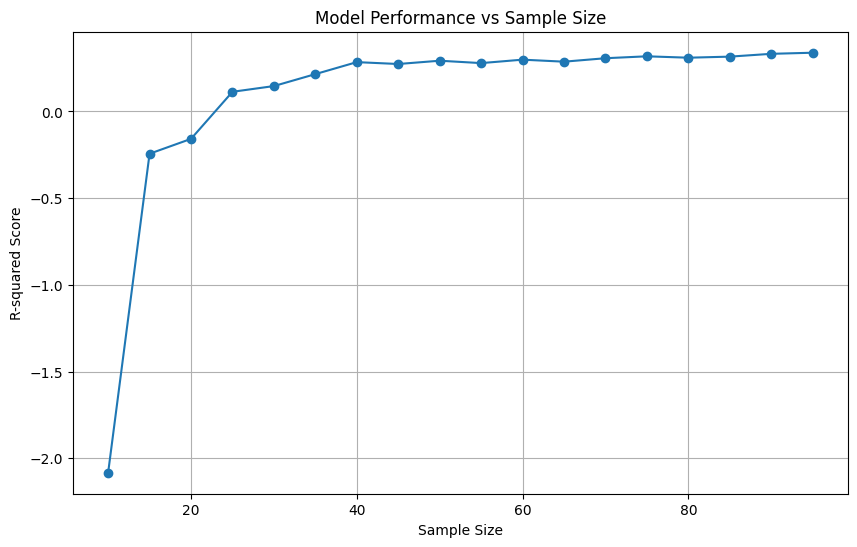

{'sample_sizes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95], 'r2_scores': [-2.083276906798749, -0.24389293127237277, -0.15821998392906877, 0.11323496799796728, 0.14627588973165373, 0.21518329678791948, 0.2842652622024031, 0.27347586746305486, 0.2924163811352247, 0.2786523254851079, 0.29850820547762713, 0.2868757960617666, 0.30679847020209505, 0.31785143811690586, 0.3098032086590691, 0.3159525103836891, 0.33217295789182877, 0.3385258018497561]}


In [90]:
print(find_optimal_sample_size(df, 'Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?'))

In [91]:
# Calculate sample size
def calculate_sample_size(population_size, sample_size):
    return int(population_size * sample_size)

# Perform simple random sampling
def perform_random_sampling(data, sample_size):
    return data.sample(n=sample_size, random_state=42)

Total population size: 106
Required sample size: 42

Sampling Validation:
Original data shape: (106, 11)
Sampled data shape: (42, 11)

Descriptive Statistics Comparison:

Original Data Summary:
       Seberapa sering Anda menggunakan ponsel (untuk telepon, chatting, atau navigasi) saat berkendara?  \
count                                         106.000000                                                   
mean                                            2.377358                                                   
std                                             0.888582                                                   
min                                             1.000000                                                   
25%                                             2.000000                                                   
50%                                             2.000000                                                   
75%                                             3.

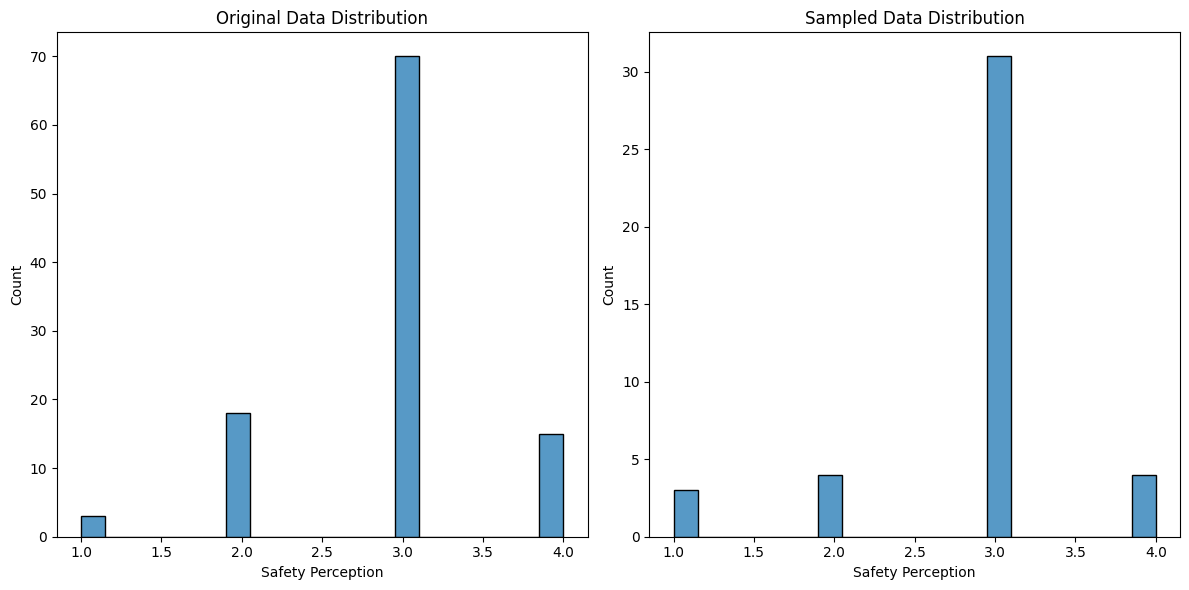

In [ ]:
# Calculate required sample size
total_population = len(df)
sample_population = 0.4  # 50% from total_population
required_sample_size = calculate_sample_size(total_population, sample_population)

print(f"Total population size: {total_population}")
print(f"Required sample size: {required_sample_size}")

# Get random sample
sampled_df = perform_random_sampling(df, required_sample_size)

# Define the target and features
Y = sampled_df['Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?']
X = sampled_df[[
    'Seberapa sering Anda menggunakan ponsel (untuk telepon, chatting, atau navigasi) saat berkendara?',
    'Seberapa sering Anda menaati batas kecepatan yang ditentukan (Dalam Perkotaan 50 Km/Jam)?',
    'Seberapa sering Anda menerobos lampu merah atau melanggar aturan lalu lintas lainnya?',
    'Apakah Anda selalu menggunakan helm/sabuk pengaman saat berkendara?',
    'Seberapa efektif rambu-rambu keselamatan di daerah Anda dalam mengurangi risiko kecelakaan? ',
    'Bagaimana penilaian Anda terhadap kecepatan respons pihak berwenang dalam menangani insiden lalu lintas? ',
    'Bagaimana penilaian Anda terhadap sistem rekayasa lalu lintas (seperti penutupan jalan atau pengaturan satu arah) dalam mengurangi kemacetan?  ',
    'Apakah fasilitas keselamatan seperti rambu dan marka jalan sudah memadai?',
    'Seberapa sering Anda merasa kondisi jalan yang Anda lewati berpotensi membahayakan pengguna jalan? ',
    'Apakah Anda merasa polisi lalu lintas konsisten dalam menegakkan peraturan?'
]]

# Validate sampling results
print("\nSampling Validation:")
print(f"Original data shape: {df.shape}")
print(f"Sampled data shape: {sampled_df.shape}")

# Descriptive statistics comparison
print("\nDescriptive Statistics Comparison:")
print("\nOriginal Data Summary:")
print(df[X.columns].describe())
print("\nSampled Data Summary:")
print(X.describe())

# Visualize sample distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?'], bins=20)
plt.title('Original Data Distribution')
plt.xlabel('Safety Perception')

plt.subplot(1, 2, 2)
sns.histplot(Y, bins=20)
plt.title('Sampled Data Distribution')
plt.xlabel('Safety Perception')

plt.tight_layout()
plt.show()

                                                        OLS Regression Results                                                       
Dep. Variable:     Apakah Anda merasa aman berkendara atau berjalan di jalan Kota Surabaya ?   R-squared:                       0.431
Model:                                                                                   OLS   Adj. R-squared:                  0.173
Method:                                                                        Least Squares   F-statistic:                     1.669
Date:                                                                       Sun, 10 Nov 2024   Prob (F-statistic):              0.152
Time:                                                                               10:07:48   Log-Likelihood:                -17.609
No. Observations:                                                                         33   AIC:                             57.22
Df Residuals:                                                 

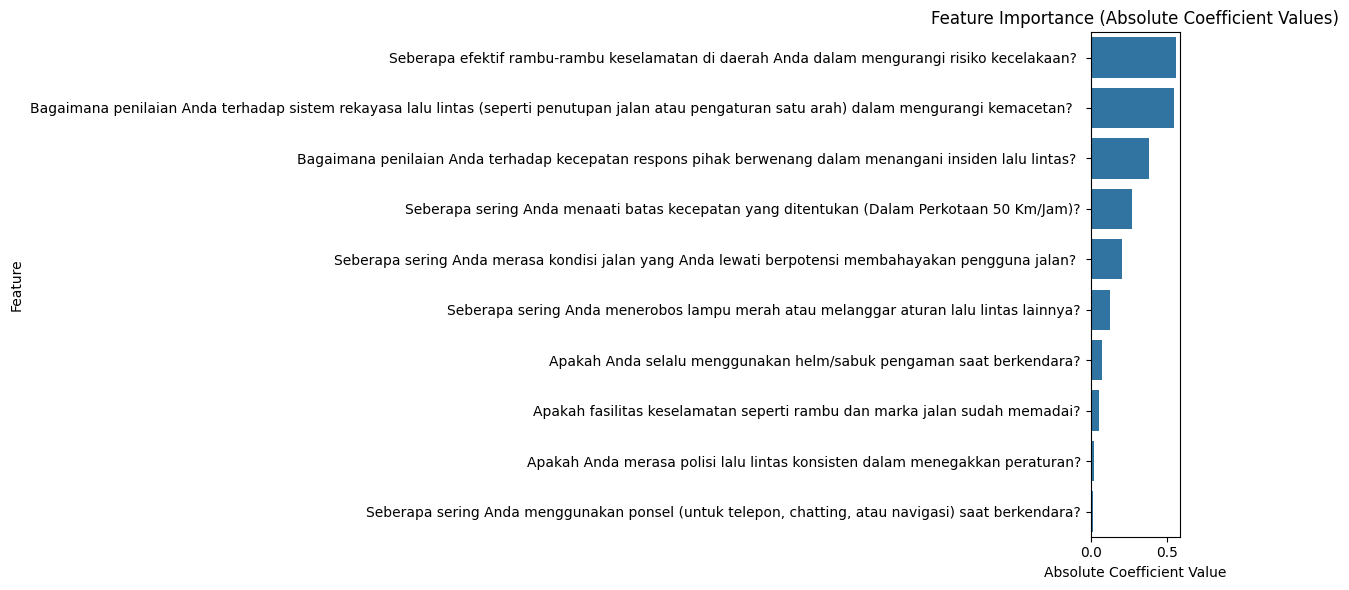

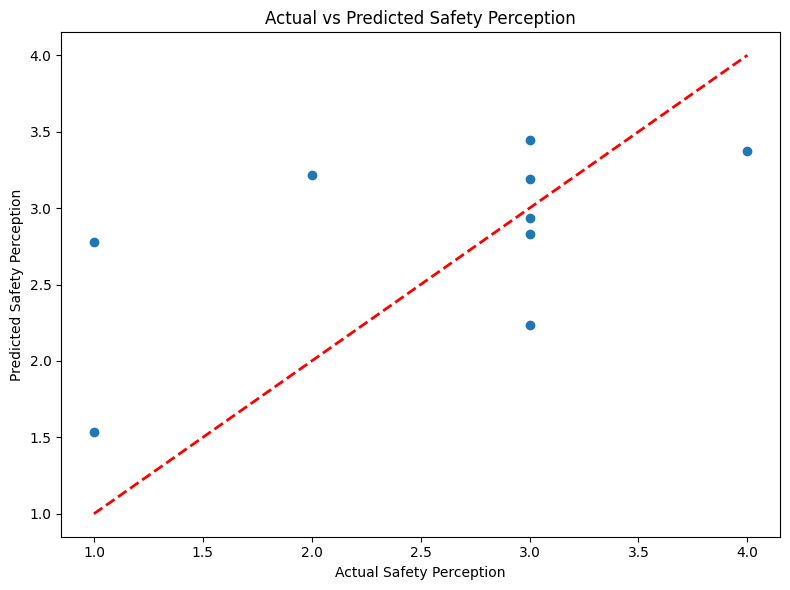

In [93]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the detailed summary (similar to R's lm() output)
X_train_sm = sm.add_constant(X_train, has_constant='add')
X_test_sm = sm.add_constant(X_test, has_constant='add')
model_sm = sm.OLS(y_train, X_train_sm).fit()
print(model_sm.summary())

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print("\nModel Performance Metrics:")
print(f"R-squared Score: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

# Create feature importance analysis
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
feature_importance['Abs_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Print feature importance
print("\nFeature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Abs_Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance (Absolute Coefficient Values)')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

# Create scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Safety Perception')
plt.ylabel('Predicted Safety Perception')
plt.title('Actual vs Predicted Safety Perception')
plt.tight_layout()
plt.show()

In [94]:
# Split data dan fit model
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

# Membuat dictionary untuk menyimpan nama variabel dan koefisien
var_names = {
    'X0': 'Penggunaan ponsel',
    'X1': 'Kepatuhan batas kecepatan',
    'X2': 'Pelanggaran lampu merah',
    'X3': 'Penggunaan helm/sabuk',
    'X4': 'Efektivitas rambu',
    'X5': 'Respons pihak berwenang',
    'X6': 'Sistem rekayasa lalu lintas',
    'X7': 'Fasilitas keselamatan',
    'X8': 'Kondisi jalan berbahaya',
    'X9': 'Konsistensi polisi'
}

# Print model regresi
print("Model Regresi Persepsi Keamanan:")
print("Y = ", end="")
for i, coef in enumerate(model.coef_):
    if i > 0:
        if coef >= 0:
            print(" +", end=" ")
        else:
            print(" -", end=" ")
        print(f"{abs(coef):.6f}(X{i})", end="")
    else:
        print(f"{coef:.6f}(X{i})", end="")
print(f" + {model.intercept_:.6f}")

# Print interpretasi model
print()
for var, name in var_names.items():
    print(f"{var} = {name}")

# Print ringkasan pengaruh
print("\nRingkasan Pengaruh Variabel:")
coef_df = pd.DataFrame({
    'Variabel': var_names.values(),
    'Koefisien': model.coef_,
    'Pengaruh': ['Positif' if c > 0 else 'Negatif' for c in model.coef_]
})
coef_df['Abs_Koefisien'] = abs(coef_df['Koefisien'])
coef_df = coef_df.sort_values('Abs_Koefisien', ascending=False)
print(coef_df[['Variabel', 'Koefisien', 'Pengaruh']])

Model Regresi Persepsi Keamanan:
Y = -0.013463(X0) + 0.272900(X1) + 0.125215(X2) + 0.075709(X3) + 0.555142(X4) + 0.381712(X5) - 0.543693(X6) - 0.057019(X7) - 0.204660(X8) + 0.019426(X9) + 1.186830

X0 = Penggunaan ponsel
X1 = Kepatuhan batas kecepatan
X2 = Pelanggaran lampu merah
X3 = Penggunaan helm/sabuk
X4 = Efektivitas rambu
X5 = Respons pihak berwenang
X6 = Sistem rekayasa lalu lintas
X7 = Fasilitas keselamatan
X8 = Kondisi jalan berbahaya
X9 = Konsistensi polisi

Ringkasan Pengaruh Variabel:
                      Variabel  Koefisien Pengaruh
4            Efektivitas rambu   0.555142  Positif
6  Sistem rekayasa lalu lintas  -0.543693  Negatif
5      Respons pihak berwenang   0.381712  Positif
1    Kepatuhan batas kecepatan   0.272900  Positif
8      Kondisi jalan berbahaya  -0.204660  Negatif
2      Pelanggaran lampu merah   0.125215  Positif
3        Penggunaan helm/sabuk   0.075709  Positif
7        Fasilitas keselamatan  -0.057019  Negatif
9           Konsistensi polisi   0.019

1. Uji Normalitas Residual


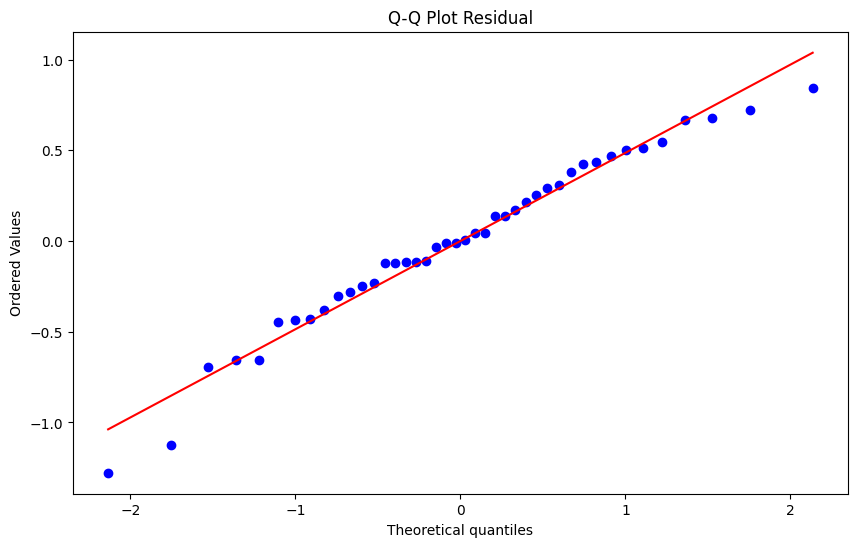

Shapiro-Wilk test: statistic=0.9721, p-value=0.3877
Kesimpulan: Residual berdistribusi normal


2. Uji Multikolinearitas
                                            Variable        VIF
0  Seberapa sering Anda menggunakan ponsel (untuk...  11.125286
1  Seberapa sering Anda menaati batas kecepatan y...  19.199529
2  Seberapa sering Anda menerobos lampu merah ata...   8.611129
3  Apakah Anda selalu menggunakan helm/sabuk peng...  48.850411
4  Seberapa efektif rambu-rambu keselamatan di da...  78.622219
5  Bagaimana penilaian Anda terhadap kecepatan re...  47.769575
6  Bagaimana penilaian Anda terhadap sistem rekay...  86.999153
7  Apakah fasilitas keselamatan seperti rambu dan...  63.830786
8  Seberapa sering Anda merasa kondisi jalan yang...  14.826085
9  Apakah Anda merasa polisi lalu lintas konsiste...  24.865100
Kesimpulan: VIF > 10 mengindikasikan multikolinearitas


3. Uji Heteroskedastisitas
Breusch-Pagan test: statistic=9.4909, p-value=0.4862
Kesimpulan: Data homoskedastis


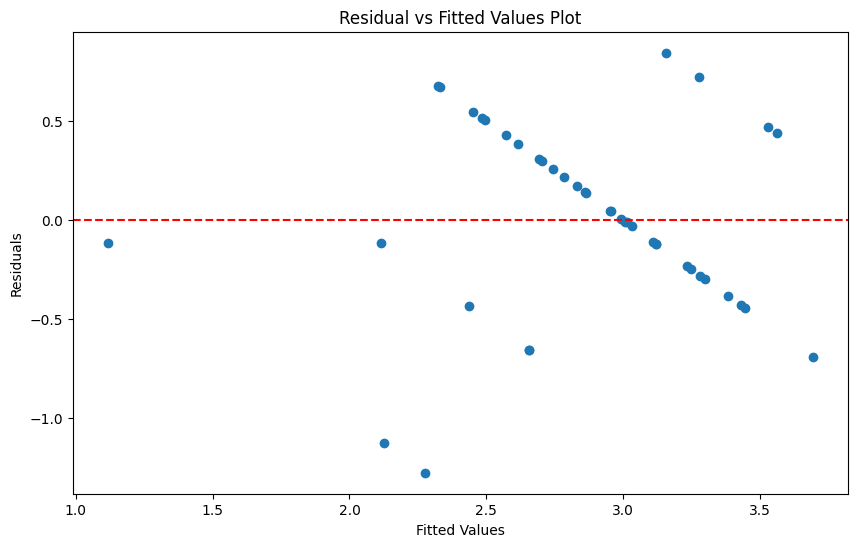



4. Uji Autokorelasi
Durbin-Watson statistic: 2.4059
Kesimpulan: Nilai mendekati 2 mengindikasikan tidak ada autokorelasi




In [95]:
def test_regression_assumptions(X, y):
    # 1. Uji Normalitas
    print("1. Uji Normalitas Residual")
    X_with_const = sm.add_constant(X)
    model = sm.OLS(y, X_with_const).fit()
    residuals = model.resid
    
    # Q-Q plot
    plt.figure(figsize=(10, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title("Q-Q Plot Residual")
    plt.show()
    
    # Uji Shapiro-Wilk
    stat, p_value = stats.shapiro(residuals)
    print(f"Shapiro-Wilk test: statistic={stat:.4f}, p-value={p_value:.4f}")
    print("Kesimpulan: Residual", "berdistribusi normal" if p_value > 0.05 else "tidak berdistribusi normal")
    print("\n" + "="*50 + "\n")
    
    # 2. Uji Multikolinearitas
    print("2. Uji Multikolinearitas")
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_data)
    print("Kesimpulan: VIF > 10 mengindikasikan multikolinearitas")
    print("\n" + "="*50 + "\n")
    
    # 3. Uji Heteroskedastisitas
    print("3. Uji Heteroskedastisitas")
    # Breusch-Pagan test
    bp_test = het_breuschpagan(residuals, X_with_const)
    print(f"Breusch-Pagan test: statistic={bp_test[0]:.4f}, p-value={bp_test[1]:.4f}")
    print("Kesimpulan: Data", "homoskedastis" if bp_test[1] > 0.05 else "heteroskedastis")
    
    # Plot residual vs fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(model.fittedvalues, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")
    plt.title("Residual vs Fitted Values Plot")
    plt.show()
    print("\n" + "="*50 + "\n")
    
    # 4. Uji Autokorelasi
    print("4. Uji Autokorelasi")
    dw_stat = durbin_watson(residuals)
    print(f"Durbin-Watson statistic: {dw_stat:.4f}")
    print("Kesimpulan: Nilai mendekati 2 mengindikasikan tidak ada autokorelasi")
    print("\n" + "="*50 + "\n")

test_regression_assumptions(X, Y)

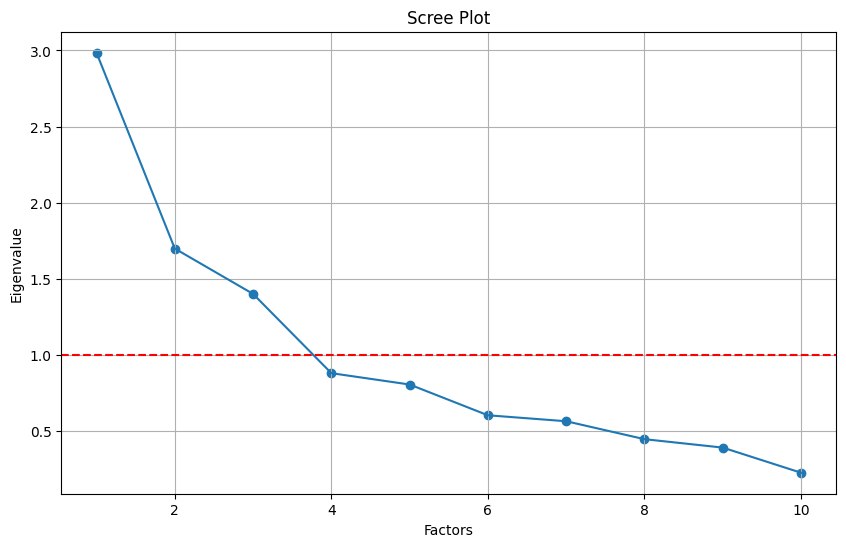

[[ 0.21783173 -0.04073736 -0.05158055  0.95045934  0.13387667  0.1510094 ]
 [-0.0600564   0.12783758  0.73833346 -0.03161881 -0.04128511 -0.00444904]
 [ 0.1210489   0.07735296  0.03784446  0.12549771 -0.18491589  0.7115584 ]
 [ 0.09534855  0.14574859  0.25584279  0.16719305  0.60539629 -0.04258583]
 [ 0.26703455  0.27667736  0.54508853 -0.01731677  0.29184795  0.15461334]
 [ 0.96384412  0.082541   -0.05212324  0.1882595  -0.02363247  0.14728748]
 [ 0.39329175  0.51173314  0.32400018  0.00155541  0.18331406  0.3196933 ]
 [ 0.09195827  0.97144991  0.19845829 -0.05302083  0.05229802  0.04192389]
 [-0.12626777 -0.0297271  -0.07841     0.00098334  0.5609348  -0.1281614 ]
 [ 0.43058574  0.31809285  0.1719333   0.16266294 -0.25113047  0.05143966]]

[[-0.06029816  0.74282496 -0.01361813  0.07656643  0.12942984]
 [ 0.22886117 -0.09703201  0.96595421  0.03570595 -0.02809127]
 [ 0.21001884  0.33916533  0.0199451  -0.01006021 -0.33121942]
 [ 0.28476485  0.22145657  0.16348487 -0.01907575  0.651392

In [96]:
chi_square_value, p_value = calculate_bartlett_sphericity(X)
chi_square_value, p_value

kmo_all, kmo_model = calculate_kmo(X)
kmo_model

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=25, rotation=None)
fa.fit(X)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

# Create scree plot using matplotlib
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ev) + 1), ev)
plt.scatter(range(1, len(ev) + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='--')
plt.grid()
plt.show()

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=6, rotation="varimax")
fa.fit(X)
print(fa.loadings_)
print()

# Create factor analysis object and perform factor analysis using 5 factors
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(X)
print(fa.loadings_)

In [97]:
def find_surrogate_variables(fa, feature_names, n_factors):
    loadings = pd.DataFrame(
        fa.loadings_,
        columns=[f'Factor{i+1}' for i in range(n_factors)],
        index=feature_names
    )
    
    surrogate_vars = {}
    
    # For each factor, find the variable with the highest absolute loading
    for factor in loadings.columns:
        abs_loadings = loadings[factor].abs()
        surrogate = abs_loadings.idxmax()
        loading_value = loadings.loc[surrogate, factor]
        surrogate_vars[factor] = {
            'variable': surrogate,
            'loading': loading_value
        }
    
    return surrogate_vars

def calculate_model_fit(X, fa):
    # Original correlation matrix
    original_corr = np.corrcoef(X.T)
    
    # Reproduced correlation matrix
    loadings = fa.loadings_
    reproduced_corr = np.dot(loadings, loadings.T)
    
    # Calculate residuals
    residuals = original_corr - reproduced_corr
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(original_corr.flatten(), reproduced_corr.flatten()))
    
    # Calculate additional fit statistics
    n_residuals = np.sum(np.abs(residuals) > 0.05)  # Number of residuals > 0.05
    total_elements = len(residuals.flatten())
    percent_large_residuals = (n_residuals / total_elements) * 100
    
    fit_stats = {
        'rmse': rmse,
        'n_large_residuals': n_residuals,
        'percent_large_residuals': percent_large_residuals
    }
    
    return fit_stats

def perform_complete_factor_analysis(X, feature_names, n_factors=5):
    # Perform factor analysis with varimax rotation
    fa = FactorAnalyzer(n_factors=n_factors, rotation='varimax')
    fa.fit(X)
    
    # Find surrogate variables
    surrogate_vars = find_surrogate_variables(fa, feature_names, n_factors)
    
    # Calculate model fit
    fit_stats = calculate_model_fit(X, fa)
    
    # Create loadings DataFrame for better visualization
    loadings_df = pd.DataFrame(
        fa.loadings_,
        columns=[f'Factor{i+1}' for i in range(n_factors)],
        index=feature_names
    )
    
    return {
        'factor_analyzer': fa,
        'loadings': loadings_df,
        'surrogate_variables': surrogate_vars,
        'model_fit': fit_stats
    }

feature_names = [
    'Seberapa sering Anda menggunakan ponsel (untuk telepon, chatting, atau navigasi) saat berkendara?',
    'Seberapa sering Anda menaati batas kecepatan yang ditentukan (Dalam Perkotaan 50 Km/Jam)?',
    'Seberapa sering Anda menerobos lampu merah atau melanggar aturan lalu lintas lainnya?',
    'Apakah Anda selalu menggunakan helm/sabuk pengaman saat berkendara?',
    'Seberapa efektif rambu-rambu keselamatan di daerah Anda dalam mengurangi risiko kecelakaan? ',
    'Bagaimana penilaian Anda terhadap kecepatan respons pihak berwenang dalam menangani insiden lalu lintas? ',
    'Bagaimana penilaian Anda terhadap sistem rekayasa lalu lintas (seperti penutupan jalan atau pengaturan satu arah) dalam mengurangi kemacetan?  ',
    'Apakah fasilitas keselamatan seperti rambu dan marka jalan sudah memadai?',
    'Seberapa sering Anda merasa kondisi jalan yang Anda lewati berpotensi membahayakan pengguna jalan? ',
    'Apakah Anda merasa polisi lalu lintas konsisten dalam menegakkan peraturan?'
]
results = perform_complete_factor_analysis(X, feature_names, n_factors=5)

print("\nFactor Loadings:")
print(results['loadings'])

print("\nSurrogate Variables:")
for factor, info in results['surrogate_variables'].items():
    print(f"{factor}: {info['variable']} (loading: {info['loading']:.3f})")

print("\nModel Fit Statistics:")
print(f"RMSE: {results['model_fit']['rmse']:.4f}")
print(f"Number of large residuals: {results['model_fit']['n_large_residuals']}")
print(f"Percent large residuals: {results['model_fit']['percent_large_residuals']:.2f}%")


Factor Loadings:
                                                     Factor1   Factor2  \
Seberapa sering Anda menggunakan ponsel (untuk ... -0.060298  0.742825   
Seberapa sering Anda menaati batas kecepatan ya...  0.228861 -0.097032   
Seberapa sering Anda menerobos lampu merah atau...  0.210019  0.339165   
Apakah Anda selalu menggunakan helm/sabuk penga...  0.284765  0.221457   
Seberapa efektif rambu-rambu keselamatan di dae...  0.538407  0.133918   
Bagaimana penilaian Anda terhadap kecepatan res...  0.305678  0.571358   
Bagaimana penilaian Anda terhadap sistem rekaya...  0.922009  0.252662   
Apakah fasilitas keselamatan seperti rambu dan ...  0.676589 -0.090196   
Seberapa sering Anda merasa kondisi jalan yang ... -0.009637 -0.061386   
Apakah Anda merasa polisi lalu lintas konsisten...  0.260200  0.228889   

                                                     Factor3   Factor4  \
Seberapa sering Anda menggunakan ponsel (untuk ... -0.013618  0.076566   
Seberapa sering And